# Demo de implementación de un Algoritmo Memético (Meme Algorithm) junto de Colonia de Abejas para resolver un SUDOKU intentando reducir la cantidad de errores
Utiliza la librería DEAP disponible en https://deap.readthedocs.io/en/master/

In [1]:
#@title Instalar librerías
!pip install deap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 3.4 MB/s eta 0:00:00


In [2]:
#@title Cargar librerías
import random
import math
import numpy as np
import matplotlib.pyplot as plt

import copy
import operator

from deap import base
from deap import creator
from deap import tools

import matplotlib
import matplotlib.pyplot as plt
import networkx
from IPython.display import display
from PIL import Image

import matplotlib as mpl
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import ipywidgets as widgets
from ipywidgets import Box, Layout, IntSlider
from ipywidgets import Layout
from IPython.display import clear_output
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

print("\nLibrerías importadas")


Librerías importadas


In [3]:
#@title PARÁMETROS

#@markdown Parámetros del Algoritmo Memético:

# Cantidad de Ciclos de la Corrida
CANT_CICLOS =  1000#@param {type:"integer"}

# Cantidad de Individuos en la Población
CANT_INDIVIDUOS_POBLACION = 50  #@param {type:"slider", min:1, max:100, step:1}

print("\nParámetros de la Corrida definidos")


#@markdown Parámetros del Algoritmo de Abejas (optimización):

#  Área de las Abejas Exploradoras
RADIO_AREA_EXPLORADORA = 50 #@param {type:"slider", min:1, max:100, step:1}
PORC_RED_AREA_EXPLORADORA = 0.3  #@param {type:"slider", min:0, max:1, step:0.05}
MIN_RADIO_AREA_EXPLORADORA = 5 #@param {type:"slider", min:1, max:100, step:1}
CANT_ABEJAS_OBRERAS_RECL_ELITE = 20 #@param {type:"slider", min:1, max:50, step:1}


print("\nParámetros de la Corrida definidos")


Parámetros de la Corrida definidos

Parámetros de la Corrida definidos


In [4]:
#@title clase SUDOKU

# @markdown Tamaño del Tablero:
Tamaño_Sudoku_NxN = '9x9'  #@param [ '4x4', '9x9', '16x16', '25x25' ]
# @markdown Indica cómo se asignan valores predefinidos del Tablero (Manual o Azar):
Manual_Valores_Predefinidos_Lista = '  4  7 3            5   7        2   6  73      8     8     3   4 3   7 1    89 6' #@param {type:"string"}
Azar_Cantidad_Valores_Predefinidos = 5 # @param {type:"slider", min:0, max:25, step:1}

# posibles valores a usar en el sudoku
SUDOKU_VALORES_POSIBLES = [' ', '1','2','3','4','5','6','7','8','9', '0', 'A','B','C','D','E','F','G','H','I','J','K','L','M','N','Ñ','O','P','Q','R','S','T','U','V','W','X','Y','Z', '!','?','#','$','%','&','/','+','*','-']

# clase Sudoku
class Sudoku(object):

    def __init__(self, Tamaño_NxN='9x9'):
      # determina tamaño del tablero (siempre es cuadrado)
      try:
        self._N = int(Tamaño_NxN.lower().split("x")[0])
      except:
        print("No se puede definir tamaño del tablero, se usa valor por defecto 9x9!")
      # determina tamaño filas / columnas (N - 1)
      self._tamFilaCol = self._N-1
      # obtiene el tamaño de las regiones (raiz cuadrada de N)
      self._tamRegion = int(self._N**0.5)
      if (self._tamRegion**2) !=  self._N:
        # controla que el tamaño es un cuadrado perfecto
        raise Exception("El tamaño del tablero no es válido: " + str(self._N) + "x" + str(self._N) + "!")
      # determina valores a usar
      if len(SUDOKU_VALORES_POSIBLES) < (self._N+1):
        # controla que haya definidos valores para tamaño tablero
        raise Exception("No existen suficientes valores (" + str(len(SUDOKU_VALORES_POSIBLES)) + ") para el tamaño del tablero: " + str(self._N) + "x" + str(self._N) + "!")
      self._ValoresUsar = SUDOKU_VALORES_POSIBLES[0: self._N+1]
      # inicializa los vectores que representan el tablero
      self.Tablero = np.zeros((self._tamFilaCol+1, self._tamFilaCol+1))

    # Función para definir los valores predefinidos del tablero al azar
    def asignarValoresAlAzar(self, cantidad=1):
      for _ in range(cantidad):
          NoAgrego = True
          cantIt = 0
          while (NoAgrego and (cantIt<100)):
            cantIt += 1
            # define posición al azar
            auxPosX = random.randint(0, self._tamFilaCol)
            auxPosY = random.randint(0, self._tamFilaCol)
            # controla que el valor no este asignado
            if self.Tablero[auxPosX][auxPosY]==0:
              # determina valor a asignar
              auxVal = random.randint(1, len(self._ValoresUsar)-1)
              # prueba agregarlo
              self.Tablero[auxPosX][auxPosY] = auxVal
              # controla que no genere error
              cantErr = self.cuentaErrores()
              if cantErr[0]==0:
                # está bien, lo deja
                NoAgrego = False
              else:
                # genera error, resetea tablero
                self.Tablero[auxPosX][auxPosY] = 0

    # Función para asignar manualmente un valor
    def asignarValorManual(self, posX, posY, valor, showMessage=False):
        # chequea posiciones
        posX = posX - 1
        if posX < 0:
          posX = 0
        elif posX > self._tamFilaCol:
          posX = self._tamFilaCol
        posY = posY - 1
        if posY < 0:
          posY = 0
        elif posY > self._tamFilaCol:
          posY = self._tamFilaCol
        # controla que el valor no este asignado
        if self.Tablero[posX][posY]>0:
          if showMessage:
            print("La posición [" + str(posX+1) + "," + str(posY+1) + "] ya está asignada: " + self._formatearValorPos(posX,posY) + "-> se ignora asignación!")
          return False
        # controla valor
        valor = str(valor)
        if valor not in self._ValoresUsar:
          if showMessage:
            print("Valor a asignar no válido: " + str(valor) + "-> se ignora asignación!")
          return False
        valorId = self._ValoresUsar.index(valor)
        # asigna
        self.Tablero[posX, posY] = valorId
        return True

    # Función para asigna valores a partir de una lista (individuo)
    def asignarValoresLista(self, valoresList, showMessage=False, esValorPos=False):
      # controla largo de lissta
      if len(valoresList) > self.devuelveTamanioTableroComoLista():
        if showMessage:
          print("Se indican más valores que los posibles a asignar, se ignora toda la lista!")
        return len(valoresList)
      # devuelve la cantidad de valores ignorados (por ya estar asignados)
      cantIgnorados = 0
      cantColumnas = self._tamFilaCol+1
      for posLista in range(len(valoresList)):
        # determina la posición
        posX = (posLista//cantColumnas)+1
        posY = (posLista%cantColumnas)+1
        valor = valoresList[posLista]
        if esValorPos:
            # el valor es el Id de Valores a usar
            valor = self._ValoresUsar[valor]
        else:
            # el valor es el Valor a usar
            valor = str(valor)
        # intenta asignarlo
        res = self.asignarValorManual(posX, posY, valor, showMessage=showMessage)
        if not(res):
          cantIgnorados += 1
      return cantIgnorados

    # Función para devolver el  tamaño debería tener el tablero como lista
    def devuelveTamanioTableroComoLista(self):
      return self._N**2

    # Función que devuelve el mínimo valor que se puede asignar en el tablero
    def devuelveMinimoValorAsignarEnTablero(self):
      return 1

    # Función que devuelve el máximo valor que se puede asignar en el tablero
    def devuelveMaximoValorAsignarEnTablero(self):
      return len(self._ValoresUsar)-1

    # Función auxiliar para contar duplicados por fila
    def _cuentaDuplicadosFila(self, matriz):
      cantDupl = 0
      for i in range(0, len(matriz)):
        uniqList, freqList = (np.unique(matriz[i], return_counts=True))
        for v, f in zip(uniqList, freqList):
          if (v>0) and (f>1):
            cantDupl += f-1
      return cantDupl

    # Función auxiliar para contar duplicados por region
    def _cuentaDuplicadosRegiones(self):
      cantDupl = 0
      rangoRegiones = range(len(self.Tablero)//self._tamRegion)
      for rX in rangoRegiones:
        # genera la región X
        iniRegionX = rX*self._tamRegion
        finRegionX = iniRegionX+self._tamRegion
        for rY in rangoRegiones:
          # genera la región Y
          auxRegion = []
          iniRegionY = rY*self._tamRegion
          finRegionY = iniRegionY+self._tamRegion
          for cols in self.Tablero[iniRegionX : finRegionX]:
            # genera la región
            auxRegion.append( cols[iniRegionY : finRegionY] )
          auxRegion = np.array(auxRegion)
          # cuenta duplicados en la region
          uniqList, freqList = (np.unique(auxRegion, return_counts=True))
          for v, f in zip(uniqList, freqList):
            if (v>0) and (f>1):
              cantDupl += f-1
      return cantDupl

    # Función para contar la cantidad de errores totales del sudo,u
    def cuentaErrores(self):
      # cuenta errores por filas
      errFilas = self._cuentaDuplicadosFila(self.Tablero)
      # cuenta errores por columnas (transpone el tablero)
      errColumnas = self._cuentaDuplicadosFila( np.transpose(self.Tablero) )
      # cuenta errores por sectores
      errRegiones = self._cuentaDuplicadosRegiones()
      # total errores
      errTotal = (errFilas+errColumnas+errRegiones)
      # sin definir
      cantZero = (self.Tablero == 0).sum()
      return errTotal, errFilas, errColumnas, errRegiones, cantZero

    # Función auxiliar para formatear valor a mostrar del tablero
    def _formatearValorPos(self, posX, posY):
      return self._ValoresUsar[ int(self.Tablero[posX][posY]) ]

    # Función que muestra la información sobre el Mapa de Búsqueda
    def printInformacion(self, mostrarErrores=True):
      print("\n** SUDOKU: " )
      ##print(self.Tablero)
      # formatea para demarcar las regiones
      print("\t", end="")
      print("--" * (self._tamFilaCol+1), end="-\n")
      for i in range(len(self.Tablero)):
        print("\t", end="|")
        for j in range(len(self.Tablero[i])):
          if j==0:
            carSep = " "
          elif ((j+1)%self._tamRegion)==0:
            carSep = "|"
          elif j==len(self.Tablero[i]):
            carSep = "|"
          else:
            carSep = " "
          print( self._formatearValorPos(i, j) , end=carSep)
        print("")
        if (((i+1)%self._tamRegion)==0) or (i==len(self.Tablero)):
          print("\t", end="")
          print("--" * (self._tamFilaCol+1), end="-\n")
      if mostrarErrores:
        # si corresponde muestra la cantidad de errores
        cantErrores = self.cuentaErrores()
        if cantErrores[4]>0:
          print("\n** Casilleros sin definir: ", cantErrores[4])
        if cantErrores[0]>0:
          print("\n** Cantidad de Errores: ", cantErrores[0])
          print("\t\t en Filas: ", cantErrores[1])
          print("\t\t en Columnas: ", cantErrores[2])
          print("\t\t en Regiones: ", cantErrores[3])
      print("\n")

print("\nClase SUDOKU definida")

# parámetros para función heruristica
PESO_IGNORADOS = 0
PESO_ERRORES_FILA = 1
PESO_ERRORES_COLUMNA = 1
PESO_ERRORES_REGION = 2
PESO_SIN_DEFINIR = 5

# clase wrapper Mapa para usar Sudoku con Abeja
class MapaSudoku(object):

  def __init__(self, sudokuOriginal, valMaximoGlobal=1000):
    self.sudokuOriginal = sudokuOriginal
    if valMaximoGlobal<0:
      self.valMaximoGlobal = sudokuOriginal.devuelveTamanioTableroComoLista()*(PESO_SIN_DEFINIR+PESO_ERRORES_REGION+PESO_ERRORES_COLUMNA+PESO_ERRORES_FILA+PESO_IGNORADOS)
    else:
      self.valMaximoGlobal = valMaximoGlobal

  @property
  def limMin(self):
    return self.sudokuOriginal.devuelveMinimoValorAsignarEnTablero()

  @property
  def limMax(self):
    return self.sudokuOriginal.devuelveMaximoValorAsignarEnTablero()

  @property
  def cantPosiciones(self):
    return self.sudokuOriginal.devuelveTamanioTableroComoLista()

  # genera nuevo soduku en base a la posiones
  def generarSudokuListaPos(self, listaPos):
    # hace una copia del sudoku original
    s = copy.deepcopy(self.sudokuOriginal)
    # prueba asignar los valores del individuo (lista valores)
    cantIgnorados = s.asignarValoresLista(list(listaPos), esValorPos=True)
    # calcula la cantidad de errores
    cantErrores = s.cuentaErrores()
    return s, cantIgnorados, cantErrores

  # definimos la función de aptitud a evaluar
  # se convierte el problema a maximizar para no afectar al algoritmo)
  def funcHeuristica(self, listaPos):
      # genera el sudoku
      _, cantIgnorados, cantErrores = self.generarSudokuListaPos(listaPos)
      # devuelve heurística
      h = self.valMaximoGlobal - (cantIgnorados*PESO_IGNORADOS
            + cantErrores[1]*PESO_ERRORES_FILA
            + cantErrores[2]*PESO_ERRORES_COLUMNA
            + cantErrores[3]*PESO_ERRORES_REGION
            + cantErrores[4]*PESO_SIN_DEFINIR)
      return h

  # muestra información
  def printInformacion(self, listaPos=None):
    if listaPos is None:
      s = self.sudokuOriginal
    else:
      s, _, _ = self.generarSudokuListaPos(listaPos)
    s.printInformacion(True)

print("\nClase MAPA-SUDOKU definida")

print("\n> Creando nuevo SUDOKU.")
sudokuOriginal = Sudoku(Tamaño_Sudoku_NxN)

# si tiene la lista mnual definida, la carga sino crea nueva clase
if Manual_Valores_Predefinidos_Lista != "":
  print("\n> Usando lista de valores predefinidos manual.")
  if "," in Manual_Valores_Predefinidos_Lista:
    listaAux = list(Manual_Valores_Predefinidos_Lista.split(","))
  else:
    listaAux = list(Manual_Valores_Predefinidos_Lista)
  sudokuOriginal.asignarValoresLista(listaAux, esValorPos=False, showMessage=True)
else:
  # asigna valores iniciales al azar
  if Azar_Cantidad_Valores_Predefinidos > 0:
    print("\n> Usando valores predefinidos al azar.")
    sudokuOriginal.asignarValoresAlAzar(Azar_Cantidad_Valores_Predefinidos)

# lo muestra
sudokuOriginal.printInformacion()

# inicializa mapa auxiliar
mapa = MapaSudoku(sudokuOriginal)



Clase SUDOKU definida

Clase MAPA-SUDOKU definida

> Creando nuevo SUDOKU.

> Usando lista de valores predefinidos manual.

** SUDOKU: 
	-------------------
	|    4|    7|  3  |
	|     |     |     |
	|    5|     |7    |
	-------------------
	|     |     |2    |
	|  6  |  7 3|     |
	|     |8    |     |
	-------------------
	|8    |     |3    |
	|  4  |3    |  7  |
	|1    |    8|9   6|
	-------------------

** Casilleros sin definir:  62




In [5]:
#@title FUNCIÓN DE APTITUD Y ESTRUCTURA DEL CROMOSOMA

#@markdown > Función de Aptitud:
#@markdown - indica que es para maximizar.
#@markdown - determina la aptitud a partir de la cantidad de errores en el sudoku.

## Inicializa objeto Toolbox auxiliar
toolbox = base.Toolbox()

# indica que es la función de aptitud es para maximizar
creator.create("Fitness", base.Fitness, weights=(1.0,))

# definimos la función de aptitud a evaluar
def funcAptitud(individuo):
    return mapa.funcHeuristica(individuo),

# registra la función que se va a evaluar
toolbox.register("evaluate", funcAptitud)

print("\nFunción de Aptitud definida")

# indica que los individuos son una lista de genes que aplica la función antes definida
creator.create("Individual", list, fitness=creator.Fitness)

# determina parámetros
genValorMin = sudokuOriginal.devuelveMinimoValorAsignarEnTablero()
genValorMax = sudokuOriginal.devuelveMaximoValorAsignarEnTablero()
genesCantidad = sudokuOriginal.devuelveTamanioTableroComoLista()

# indica que los genes son enteros
toolbox.register("attr_int", random.randint, genValorMin, genValorMax)

# registra el tipo de individuo y población a usar
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_int, genesCantidad)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)


print("\nCromosoma definido")


Función de Aptitud definida

Cromosoma definido


In [6]:
#@title clase ABEJA (auxiliar para operador de OPTIMIZACIÓN)


tipo_abeja = "Especial" #@param ["Normal","Especial"]
#@markdown Nota:
#@markdown - En la versión "Normal" se aplican el concepto normal de área para reclutar las abejas Obreras (se consideran áreas continuas).

#@markdown - Pero en la versión "Especial", el área se usa como la probabilidad de que cambie cada posición de la exploradora dentro del rango de valores válidos (áreas discretas).

# determina tipo abeja
esTipoAbejaNormal = (tipo_abeja == "Normal")

class Abeja(object):

    def __init__(self, mapa=None, radioArea=0, tipoAbejaNormal=True):
        self._tipoAbejaNormal = tipoAbejaNormal
        self.pos = []
        if mapa == None:
            self.radio = 0
            self.radioIni = 0
            self.valor = -9999
            self.explOriginal = False
            self.algunaObreraMejor = False
        else:
            self.explOriginal = True
            self.radioIni = radioArea
            self.reUbicarse(mapa)

    def _reset(self):
        self.pos = []
        self.radio = 0
        self.valor = -9999
        self.explOriginal = False
        self.algunaObreraMejor = False

    def reUbicarse(self, mapa):
        # inicializa valores
        self.radio = self.radioIni
        self.algunaObreraMejor = False
        # asigna posición
        limMin, limMax = mapa.limMin, mapa.limMax
        self.pos = [random.randint(limMin, limMax) for _ in range(mapa.cantPosiciones)]
        # asigna heurística
        self.valor = mapa.funcHeuristica(self.pos)

    @property
    def heuristica(self):
        return round(self.valor, 2)


    @property
    def esExploradoraOriginal(self):
        return self.explOriginal

    @property
    def posicion(self):
        return self.pos

    @property
    def tieneArea(self):
        return self.radio>0

    def reclutarObreras(self, mapa, cantObrerasReclutadas, \
                        radioAreaExpl=RADIO_AREA_EXPLORADORA):
        # Si el radio del área es nulo, no se generan
        if self.radio <= 0:
            return []
        limMin, limMax = mapa.limMin, mapa.limMax
        self.algunaObreraMejor = False
        obrerasReclutadasNuevas = []
        for i in range(cantObrerasReclutadas):
              # Crea una nueva abeja a la que le asigna una posción relativa a la exploradora padre
              # y luego calcula su herística
              nOb = Abeja(tipoAbejaNormal=esTipoAbejaNormal)
              for posI in self.pos:
                if self._tipoAbejaNormal:
                    # reclutar abejas normales
                    newPosI = random.randint(int(posI-self.radio), int(posI+self.radio))
                    newPosI = min(max(newPosI, limMin), limMax)
                else:
                    # reclutar abejas especiales
                    if random.random() < self.radio:
                      newPosI = random.randint(limMin, limMax)
                    else:
                      # mantiene la misma
                      newPosI = posI
                nOb.pos.append(newPosI)
              # asigna heurística
              nOb.valor = mapa.funcHeuristica(nOb.pos)
              if nOb.valor > self.valor:
                  # si la nueva obra es mejor que la padre,
                  #    pasa a ser una exploradora
                  nOb.radio = radioAreaExpl
                  self.algunaObreraMejor = True
              # agrega reclutada
              obrerasReclutadasNuevas.append( nOb )
        return obrerasReclutadasNuevas

    def reducirArea(self, mapa, porcRedAreaExpl = PORC_RED_AREA_EXPLORADORA, minAreaExpl=MIN_RADIO_AREA_EXPLORADORA):
        if self.algunaObreraMejor:
          # Si hay alguna obrera mejor, no se reduce
          # pero se reseta ese valor para la próxima vez
          self.algunaObreraMejor = False
          return False
        else:
          # Cuando ninguna obrera es mejor,
          #     se reduce el área de la abeja exploradora
          self.radio = self.radio * (1-porcRedAreaExpl)
          if self.radio <= minAreaExpl:
              # se define radio vacío
              self.radio = 0
              if self.explOriginal:
                # si es de las exploradoras originales
                # se reubica en el mapa
                posAnt = self.pos
                self.reUbicarse(mapa)
                ##print("    +++ Abeja exploradora reubicada de ", posAnt," a ", self.pos,"-->",  self.valor)
          return True

    def hacerExploradoraArea(self, radioArea):
        self.radio = radioArea
        return self.radioArea

    def cambiarPosicion(self, mapa, nuevaPosicion):
        self.radio = self.radioIni
        self.pos = nuevaPosicion
        self.valor = mapa.funcHeuristica(self.pos)
        return self.valor

print("\nClase auxiliar Abeja definida")


Clase auxiliar Abeja definida


In [7]:
#@title OPERADORES GENÉTICOS
## (ver lista completa en https://deap.readthedocs.io/en/master/api/tools.html#operators )

tipo_seleccion = 'Torneo' #@param ["Azar", "Torneo", "Ranking", "Ruleta"]
tipo_cruzamiento = 'Azar' #@param ["Simple-1Punto", "Simple-2Puntos", "Azar"]
#@markdown ####tipo_mutacion:  "Algoritmo de Abeja"

# Registrar tipo de Selección a aplicar con sus parámetros
if tipo_seleccion == 'Torneo':
  toolbox.register("select", tools.selTournament, tournsize=2)
elif tipo_seleccion == 'Ranking':
  toolbox.register("select", tools.selBest)
elif tipo_seleccion == 'Ruleta':
  toolbox.register("select", tools.selRoulette)
else:
  toolbox.register("select", tools.selRandom)

# Registrar tipo de Cruzamiento a aplicar con sus parámetros
if tipo_cruzamiento == 'Simple-1Punto':
  toolbox.register("mate", tools.cxOnePoint)
elif tipo_cruzamiento == 'Simple-2Puntos':
  toolbox.register("mate",  tools.cxTwoPoint)
else:
  toolbox.register("mate", tools.cxUniform, indpb=1/genesCantidad)


# Define la función de OPTIMIZACIÓN
#           que usa un ciclo del Algortimo de Colonia de Abjeas
# Recibe como parámetro el individuo a mutar y el mapa de búsqueda
# Devuelve el individuo optimizado
def OptimizarPos(individual, mapa, radioAreaExpl, cantAbejasReclutar):

    # crea la abeja exploradora en la posición del indivio
    b = Abeja(mapa, radioArea=radioAreaExpl)
    b.cambiarPosicion(mapa, individual)

    # realiza la reclutación de abejas obreras
    reclObreras = b.reclutarObreras(mapa, cantAbejasReclutar)

    # evalúa las abejas reclutadas con la original  para determinar la mejor
    reclObreras.append( b )
    rankingAbejas = sorted([b for b in reclObreras], key=operator.attrgetter('heuristica'), reverse=True)
    mejorAbeja = rankingAbejas[0]

    # actualiza el individuo con la mejor abeja encontrada
    for i in range(len(individual)):
          individual[i] = mejorAbeja.posicion[i]

    return individual,

# Registrar tipo de Mutación a aplicar con sus parámetros
toolbox.register("mutate", OptimizarPos, mapa=mapa, radioAreaExpl=RADIO_AREA_EXPLORADORA, cantAbejasReclutar=CANT_ABEJAS_OBRERAS_RECL_ELITE)

print("\nOperadores Genéticos definidos")


Operadores Genéticos definidos


In [8]:
#@title FUNCIONES AUXILIARES

## Define una función auxiliar para calcular estadísticas y guarda info en vectores auxiliares
def CalculoEstadisticas(ciclo, indivPobla, muestra, mejorMax = True):
    global mejorIndCorrida, mejorIndCorrida_ciclo
    global ciclosMaxAptitud
    global ciclosPromAptitud
    global ciclosMinAptitud
    if len(indivPobla) == 0:
      return None, 0, 0, 0
    auxMax = None
    auxMin = None
    auxSum = 0
    auxBestInd = None
    auxBestIndApt = None
    for ind in indivPobla:
        apt = round(ind.fitness.values[0], 2)
        auxSum = auxSum + apt
        if (auxMax == None) or (apt > auxMax):
            auxMax = apt
            if mejorMax:
              auxBestInd = ind
              auxBestIndApt = apt
        if (auxMin == None) or (apt < auxMin):
            auxMin = apt
            if not mejorMax:
              auxBestInd = ind
              auxBestIndApt = apt
    auxProm = round(auxSum / len(indivPobla), 2)
    if mejorMax:
      if (mejorIndCorrida == None) or (mejorIndCorrida.fitness.values < auxBestInd.fitness.values):
            mejorIndCorrida = auxBestInd
            mejorIndCorrida_ciclo = ciclo
    else:
      if (mejorIndCorrida == None) or (mejorIndCorrida.fitness.values > auxBestInd.fitness.values):
            mejorIndCorrida = auxBestInd
            mejorIndCorrida_ciclo = ciclo
    ciclosMaxAptitud.append( auxMax )
    ciclosPromAptitud.append( auxProm )
    ciclosMinAptitud.append( auxMin )
    if muestra:
        print("\n-- Ciclo  %i --" % ciclo)
        print(" ++ Mejor Individuo:", auxBestInd, "\n\t\t\t {", round(auxBestIndApt, 3), "}")
        print("      Max: ", round(auxMax, 3), " / Promedio: ", round(auxProm, 3), " / Min: ", round(auxMin, 3))
    return auxBestInd, auxMax, auxProm, auxMin


def asignarAptitud(indivPobla):
  # Asigna el valor de aptitud a los individuos
  fitnesses = list(map(toolbox.evaluate, indivPobla))
  for ind, fit in zip(indivPobla, fitnesses):
      ind.fitness.values = fit


def mostrarParamsDetalle():
  print("EJECUCIÓN DE LA CORRIDA: ")
  print("\t Criterio de Paro: "+str(CANT_CICLOS)+" ciclos, o si llega a una heurística mayor a: ", round(MIN_HEURISTICA_FINALIZAR,3) )
  print("\t Tamaño de la Población: "+str(CANT_INDIVIDUOS_POBLACION)+" individuos.")
  print("\t Método de Selección: "+tipo_seleccion+".")
  print("\t Método de Cruzamiento: "+tipo_cruzamiento+".")
  print("\t Método de Mutación: Simple con "+str(probab_mutacion*100)+"% de probabilidad.")
  print("")


def mostrarPoblaDetalle(indivPobla, titulo=""):
  if titulo != "":
    print("\n" + titulo)
  for ind in indivPobla:
    print("\t", formatearIndividuo(ind), " { ", formatearAptitud(ind.fitness.values[0]), " } ")
  print("")

print("\nFunciones auxiliares definidas")


Funciones auxiliares definidas


In [9]:
#@title EJECUCIÓN DE LA CORRIDA

# Indica si se muestra el detalle de las estadísticas en cada ciclo
MUESTRA_ESTADISTICAS = True  #@param {type:"boolean"}

# Muestra su información
mapa.printInformacion()

# Determina mínima Heuristica para finalizar el algoritmo
MIN_HEURISTICA_FINALIZAR = mapa.valMaximoGlobal - 1

# cálcula cantidad de individuos seleccionados como la mitad + 1
cant_ind_selecc = (CANT_INDIVIDUOS_POBLACION//2)+1

# vectores auxiliares
ciclo = 1
mejorIndCorrida = None
mejorIndCorrida_ciclo = 0
ciclosIndiv = []
ciclosMaxAptitud = []
ciclosPromAptitud = []
ciclosMinAptitud = []

# siempre aplica la "mutación" / optimización
probab_mutacion = 1.0

# Define la población inicial
indivPobla = toolbox.population(n=CANT_INDIVIDUOS_POBLACION)

# Asigna el valor de aptitud a los individuos de la población inicial
asignarAptitud(indivPobla)
ciclosIndiv.append( [] )
ciclosIndiv[0].extend( indivPobla )

# Cálcula estadísticas y guarda info en vectores auxiliares
auxBestInd, auxMax, auxProm, auxMin = CalculoEstadisticas(0, indivPobla, MUESTRA_ESTADISTICAS)

# Finaliza cuando llegue a la cantidad de ciclos
#     o cuando la heurística del mejor sea mayor a un mínimo
while (ciclo < CANT_CICLOS) \
        and ((mejorIndCorrida==None) or (mejorIndCorrida.fitness.values[0]<MIN_HEURISTICA_FINALIZAR)):

    # Realiza la Selección
    indivSelecc = toolbox.select(indivPobla, cant_ind_selecc)

    # Realiza el Cruzamiento
    # por cada individuo seleccionado los clona (sino pueden afectarle los cambios)
    # y luego le busca una pareja al azar dentro de los seleccionados para generar 2 hijos
    indivHijos = []
    for hijo1 in list(map(toolbox.clone, indivSelecc)):
      if len(indivHijos) < len(indivPobla):
        # todavía falta generar hijos
        hijo2 = list(map(toolbox.clone, random.sample(indivSelecc, 1)))[0]
        # hace el cruzamiento
        toolbox.mate(hijo1, hijo2)
        del hijo1.fitness.values
        del hijo2.fitness.values
        # agrega 1er hijo
        indivHijos.append(hijo1)
        if len(indivHijos) < len(indivPobla):
          # agrega 2do hijo
          indivHijos.append(hijo2)
      else:
        break

    # controla que mantenga que los hijos
    # tenga la misma cantidad de individuos que la población original
    if len(indivHijos) != len(indivPobla):
      print("ERROR: distinta cantidad de individuos hijos ", len(indivHijos) , " | ", len(indivPobla))

    # Realiza la Mutación
    if random.random() < probab_mutacion:
      # ejecuta mutación:
      # selecciona al azar el individuo a mutar
      # y lo muta aplicando el método
      mutant = indivHijos[random.randint(0, len(indivHijos)-1)]
      # hace la mutación
      toolbox.mutate(mutant)
      del mutant.fitness.values

    # Evalua a los individuos hijos que salen de Cruzamiento & Mutación
    #  para determinar si son válidos y su valor de aptitud
    invalid_ind = [ind for ind in indivHijos if not ind.fitness.valid]
    asignarAptitud(invalid_ind)

    # Reemplaza la población actual con los hijos
    indivPobla[:] = indivHijos
    ciclosIndiv.append( [] )
    ciclosIndiv[ciclo].extend( indivPobla )

    # Cálcula estadísticas y guarda info en vectores auxiliares
    auxBestInd, auxMax, auxProm, auxMin = CalculoEstadisticas(ciclo, indivPobla, MUESTRA_ESTADISTICAS)

    ciclo = ciclo + 1

print("\n-- Corrida Finalizada en %i ciclos --\n" % ciclo )
print("== Mejor Individuo de la Corrida:", mejorIndCorrida, "\n\t\t\t { ", round(mejorIndCorrida.fitness.values[0], 3), " }  ==")
mapa.printInformacion(mejorIndCorrida)

Se han truncado las últimas 5000 líneas del flujo de salida.
 ++ Mejor Individuo: [7, 4, 9, 4, 1, 6, 4, 2, 6, 9, 3, 4, 2, 7, 6, 7, 5, 1, 8, 6, 6, 6, 4, 9, 5, 4, 6, 2, 3, 3, 9, 3, 8, 9, 1, 6, 6, 7, 5, 9, 3, 6, 2, 6, 8, 2, 3, 1, 1, 4, 5, 6, 3, 4, 9, 2, 4, 7, 1, 3, 8, 9, 6, 6, 2, 9, 7, 2, 6, 8, 4, 1, 7, 7, 4, 5, 6, 1, 1, 5, 6] 
			 { 906.0 }
      Max:  906.0  / Promedio:  902.46  / Min:  897.0

-- Ciclo  6 --
 ++ Mejor Individuo: [7, 4, 9, 4, 1, 6, 4, 2, 6, 9, 3, 4, 2, 7, 6, 7, 5, 1, 8, 6, 6, 6, 4, 9, 5, 4, 6, 2, 3, 3, 9, 3, 8, 9, 1, 6, 6, 7, 5, 9, 3, 6, 2, 6, 8, 2, 9, 1, 1, 4, 5, 6, 3, 4, 9, 2, 4, 7, 1, 3, 8, 9, 6, 6, 2, 9, 7, 2, 6, 8, 4, 1, 7, 7, 4, 5, 6, 1, 1, 5, 6] 
			 { 910.0 }
      Max:  910.0  / Promedio:  903.76  / Min:  899.0

-- Ciclo  7 --
 ++ Mejor Individuo: [7, 4, 9, 4, 1, 6, 4, 2, 6, 9, 3, 4, 2, 7, 6, 7, 5, 1, 8, 6, 6, 6, 4, 9, 5, 4, 6, 2, 3, 3, 9, 3, 8, 9, 1, 6, 6, 7, 5, 9, 3, 6, 2, 6, 8, 2, 9, 1, 1, 4, 5, 6, 3, 4, 9, 2, 4, 7, 1, 3, 8, 9, 6, 6, 2, 9, 7, 2, 6, 8, 4, 1, 7

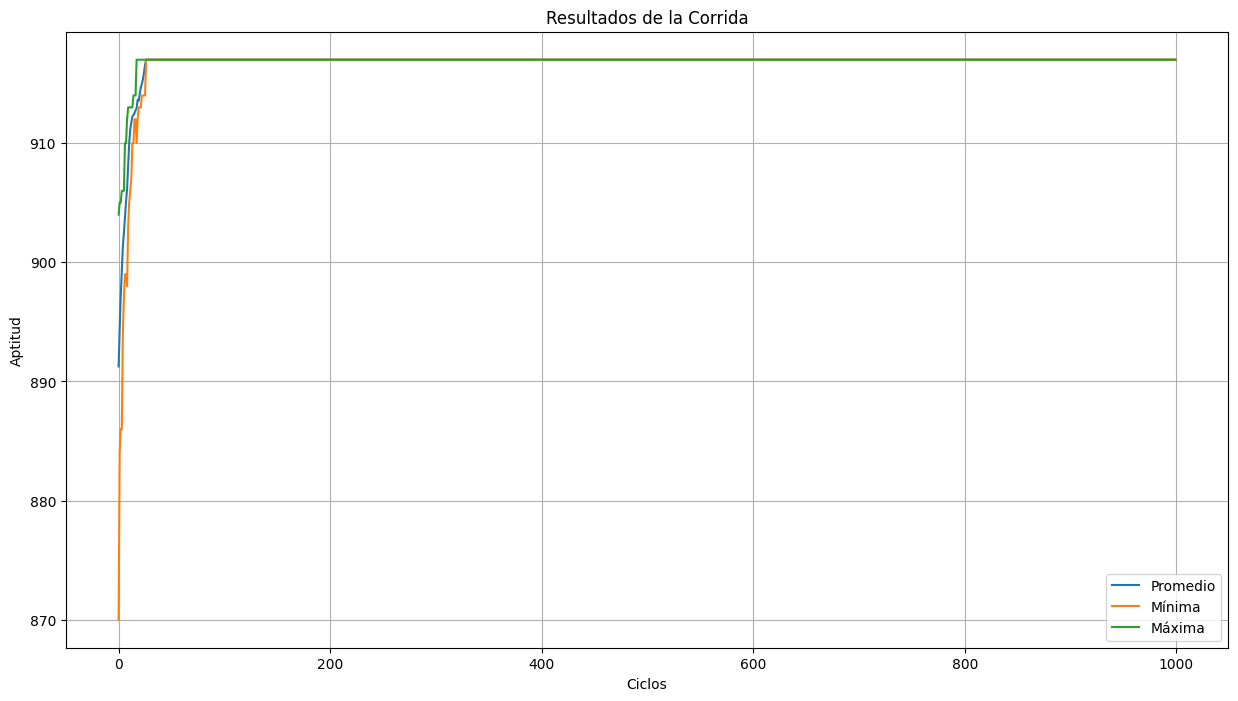

In [10]:
#@title MOSTRAR GRAFICO DE LA CORRIDA
plt.figure(figsize=(15,8))
plt.plot(ciclosPromAptitud)
plt.plot(ciclosMinAptitud)
plt.plot(ciclosMaxAptitud)
plt.title('Resultados de la Corrida')
plt.xlabel('Ciclos')
plt.ylabel('Aptitud')
plt.legend(['Promedio', 'Mínima', 'Máxima'], loc='lower right')
plt.grid(True)
plt.show()
